In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import random
import re
from validation_functions import *

from numba import njit

plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 22
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

/tmp/ipykernel_215446/3188817658.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


In [16]:
from scipy.optimize import fsolve

def correct_angle(theta):
    correct_t=[]
    for xtheta in theta:
        while xtheta>2*np.pi :
            xtheta=xtheta-2*np.pi
        while xtheta<0 :
            xtheta=xtheta+2*np.pi
        correct_t.append(xtheta)
    return correct_t

def cal_geodesics(ri, rj, thetai,thetaj):    
    #chose small theta_x 
    if abs(thetai-thetaj)<np.pi:
        theta1=min(thetai,thetaj)
        theta2=max(thetai,thetaj)
        theta_x=np.linspace(theta1, theta2, 100)
    else:
        theta1=min(thetai,thetaj)
        theta2=max(thetai,thetaj)
        theta_x=np.linspace(theta2, theta1+2*np.pi, 100)
        
    theta_x=correct_angle(theta_x)
    
    r_x=[]
    t_ij=theta_ij(thetai,thetaj)
    dij=np.arccosh( 0.5*((1.0-np.cos(t_ij))*np.cosh(ri+rj) + (1.0+np.cos(t_ij))*np.cosh(ri-rj)) )
    for tx in theta_x:
        t_ix=theta_ij(thetai,tx)
        t_jx=theta_ij(thetaj,tx)
        data = (ri,rj,t_ix,t_jx,dij)
        rx0 = ri
        rx = fsolve(geodesic_function, rx0, args=data)       
        #print rx
        r_x.append(rx[0])
    return r_x,theta_x

def theta_ij(thetai,thetaj):
    dij=np.pi-abs(np.pi-abs(thetai-thetaj))
    return dij

def geodesic_function(rx, *arguments):
    ri,rj,t_ix,t_jx,dij=arguments
    fx=np.arccosh( 0.5*((1.0-np.cos(t_ix))*np.cosh(ri+rx) + (1.0+np.cos(t_ix))*np.cosh(ri-rx)) ) \
            +np.arccosh( 0.5*((1.0-np.cos(t_jx))*np.cosh(rj+rx) + (1.0+np.cos(t_jx))*np.cosh(rj-rx)) ) \
            -dij
    return fx

def change_coord_for_geodesics(theta, r):
    x=[]
    y=[]   
    for i in range(len(r)):
        x.append(r[i]*np.cos(theta[i]))
        y.append(r[i]*np.sin(theta[i]))     
    return x,y

def connection_prob(thetai,thetaj,kappai,kappaj,R,beta,mu):
    dtheta=np.pi-abs(np.pi-abs(thetai-thetaj))
    xij=R*dtheta/(mu*kappai*kappaj)
    pij=1.0/(1+xij**beta)
    return pij

def change_coord(G, df):
    x={}
    y={}    
    for i in G.nodes():
        df_i = df[df['index'] == int(i)]
        r_i = df_i['hyp_radius'].values[0]
        theta_i = df_i['theta'].values[0]
        x[int(i)]=r_i*np.cos(theta_i)
        y[int(i)]=r_i*np.sin(theta_i)
    return x, y

In [84]:
path_edgelist = '/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/validation/check_coordinates/dim_1_B_s_3_g_s_2.7_Ns_obs_500_k_s_10_g_n_2.7_k_n_10_g_f_2.1_N_f_1000_B_bi_1.5_c_0.0_i_0/eS1/net.bipartite.edge'

with open(path_edgelist, 'r') as f:
    edges = []
    for line in f:
        if '#' in line:
            continue
        edges.append(line.split())

In [149]:
path_nodes = '/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/validation/check_coordinates/dim_1_B_s_3_g_s_2.7_Ns_obs_500_k_s_10_g_n_2.7_k_n_10_g_f_2.1_N_f_1000_B_bi_1.5_c_0.0_i_0/eS1/net.bipartite.inf_coord_nodes'
path_features = '/home/rob/MEGAsync/datasets/networks/Synthetic/fix_slow_version/f-mercator-networks/paper_simulations/validation/check_coordinates/dim_1_B_s_3_g_s_2.7_Ns_obs_500_k_s_10_g_n_2.7_k_n_10_g_f_2.1_N_f_1000_B_bi_1.5_c_0.0_i_0/eS1/net.bipartite.inf_coord_features'


df_nodes = pd.read_csv(path_nodes, sep="\s+", header=None, comment="#")
df_nodes.columns = ['index', 'kappa', 'theta', 'inf_radius']

df_features = pd.read_csv(path_features, sep="\s+", header=None, comment="#")
df_features.columns = ['index', 'kappa', 'theta', 'inf_radius']

subset_edges = random.sample(edges, 30)
subset_nodes = [x[0] for x in subset_edges]
subset_features = [x[1] for x in subset_edges]

df_nodes = df_nodes[df_nodes['index'].isin(subset_nodes)]
df_features = df_features[df_features['index'].isin(subset_features)]

# df_nodes = df_nodes.sample(20)
# df_features = df_features.sample(10)

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_215446/1973608884.py:34: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  rx = fsolve(geodesic_function, rx0, args=data)
/tmp/ipykernel_215446/1973608884.py:45: RuntimeWarning: overflow encountered in cosh
  fx=np.arccosh( 0.5*((1.0-np.cos(t_ix))*np.cosh(ri+rx) + (1.0+np.cos(t_ix))*np.cosh(ri-rx)) ) \
/tmp/ipykernel_215446/1973608884.py:46: RuntimeWarning: overflow encountered in cosh
  +np.arccosh( 0.5*((1.0-np.cos(t_jx))*np.cosh(rj+rx) + (1.0+np.cos(t_jx))*np.cosh(rj-rx)) ) \
/tmp/ipykernel_215446/1973608884.py:46: RuntimeWarning: invalid value encountered in multiply
  +np.arccosh( 0.5*((1.0-np.cos(t_jx))*np.cosh(rj+rx) + (1.0+np.cos(t_jx))*np.cosh(rj-rx)) ) \


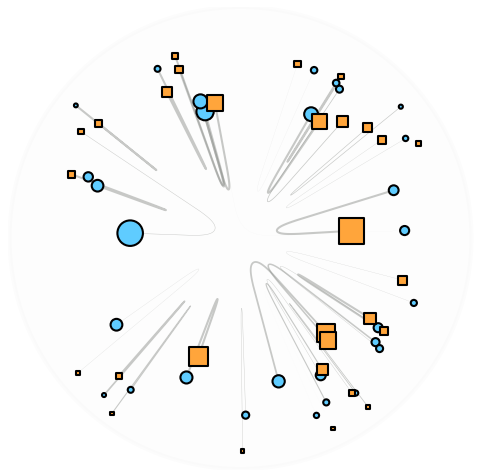

In [155]:
fig, ax = plt.subplots(figsize=(8, 8))

df_nodes['x'] = df_nodes['inf_radius'] * np.cos(df_nodes['theta'])
df_nodes['y'] = df_nodes['inf_radius'] * np.sin(df_nodes['theta'])

df_features['x'] = df_features['inf_radius'] * np.cos(df_features['theta'])
df_features['y'] = df_features['inf_radius'] * np.sin(df_features['theta'])

colors = ['#5FCCFF', '#FFA53B']

max_kappa = df_nodes['kappa'].max()
ax.scatter(df_nodes['x'], df_nodes['y'], s=600*df_nodes['kappa']/max_kappa, edgecolors='black',color=colors[0], 
           alpha=1, linewidths=2, zorder=2)
max_kappa = df_features['kappa'].max()
ax.scatter(df_features['x'], df_features['y'], s=600*df_features['kappa']/max_kappa, edgecolors='black',
           color=colors[1],marker='s', alpha=1, linewidths=2, zorder=2)

ax.set_xticks([])    
ax.set_yticks([])
ax.axis('off')
ax.axis('equal')

R = 79.5775
beta = 2.96
mu = 0.0383

for u,v in tqdm(subset_edges):
    df_u = df_nodes[df_nodes['index'] == u]
    df_v = df_features[df_features['index'] == v]
    
    if len(df_u) == 0 or len(df_v) == 0:
        continue
        
    r_u = df_u['inf_radius'].values[0]
    theta_u = df_u['theta'].values[0]
    kappa_u = df_u['kappa'].values[0]
    
    r_v = df_v['inf_radius'].values[0]
    theta_v = df_v['theta'].values[0]
    kappa_v = df_v['kappa'].values[0]
    
    pij=connection_prob(theta_u, theta_v, kappa_u, kappa_v, R, beta, mu)
    
    r_x, theta_x = cal_geodesics(r_u, r_v, theta_u, theta_v)
    xg, yg = change_coord_for_geodesics(theta_x, r_x)   
    ax.plot(xg, yg, linewidth=2*pij, c='xkcd:grey', zorder=1, alpha=0.5)                                


rmax=max(df_features['inf_radius'])+1
    
theta_angle=np.linspace(0, np.pi, 100)
xc=[]
y_upper = []
y_lower = []
for thetax in theta_angle:
    xc.append(rmax*np.cos(thetax))
    y_upper.append(rmax*np.sin(thetax))
    y_lower.append(-rmax*np.sin(thetax) )

ax.fill_between(xc, y_upper, y_lower,linewidth=4, facecolor='grey',
                 edgecolor='k',zorder=-5, alpha=0.01)

ax.set_ylim(-rmax,rmax)
ax.set_xlim(-rmax,rmax)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/greedy_routing_sketch.svg")
